# CLUSTERING - K-MEANS

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [57]:
pp_train = pd.read_csv("pp_train.csv")
pp_train.head()

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,is_Fantasy,is_Family,is_Mystery,is_Talk-Show,is_Drama,is_Sport,is_War,is_Horror,is_Animation,fill_runtimeMinutes
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,NaN,NaN,0.0,779,1,0,21,...,0,0,0,0,0,0,0,0,1,40.0
1,Looping,6,1982,NaN,NaN,0.0,11,1,0,1,...,0,0,0,0,0,0,0,0,0,28.0
2,Idealnaya para,6,1992,NaN,NaN,0.0,38,1,0,24,...,0,0,0,0,0,0,0,0,0,90.0
3,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,22,0,56,...,0,0,0,0,0,0,0,0,0,31.0
4,Seutateueob,8,2020,2020.0,80.0,1.0,15718,347,2,47,...,0,0,0,0,1,0,0,0,0,80.0


In [58]:
pp_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'countryOfOrigin', 'is_Documentary', 'is_History', 'is_Adventure',
       'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance',
       'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir',
       'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime',
       'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show',
       'is_Drama', 'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes'],
      dtype='object')

### Create a copy of the df to avoid changing the original one

In [59]:
pp_train_copy = pp_train.copy()

### Convert canHaveEpisodes in a binary 0-1 feature for better handling

In [60]:
pp_train_copy['canHaveEpisodes'] = pp_train_copy['canHaveEpisodes'].astype(int)

### Convert rating.unique values to binary variables 

In [61]:
# Create binary variables for each rating value
for rating_value in pp_train_copy["rating"].unique():
    pp_train_copy[f"rating = {rating_value}"] = (pp_train_copy["rating"] == rating_value).astype(int)

### Checking the results

In [62]:
pp_train_copy.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'countryOfOrigin', 'is_Documentary', 'is_History', 'is_Adventure',
       'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance',
       'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir',
       'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime',
       'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show',
       'is_Drama', 'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'rating = 8', 'rating = 6', 'rating = 9',
       'rating = 7', 'rating = 3', 'rating = 5', 'rating = 10', 'rating = 4',
       'rating = 1', 'rating = 2'],
      dtype='object')

In [63]:
pp_train_copy["canHaveEpisodes"]

0        0
1        0
2        0
3        1
4        1
        ..
16426    0
16427    0
16428    0
16429    0
16430    0
Name: canHaveEpisodes, Length: 16431, dtype: int32

### Definizione delle feature numeriche da usare per clustering

In [64]:
numeric = pp_train_copy[["startYear", "awardWins", "numVotes", "totalImages", "totalVideos", "totalCredits", "criticReviewsTotal", 
                    "awardNominationsExcludeWins", "numRegions", "userReviewsTotal", "fill_runtimeMinutes"]]

### Log-transformation delle variabili numeriche

In [65]:
data_log = np.log1p(numeric)
X_numeric_log = data_log.values
#X = pp_train.iloc[:,:].values ---> questo comodo se nel dataset avessimo solo var numeriche

### Normalizzazione con z-score e minmax

In [66]:
scaler = StandardScaler() 
scaler.fit(X_numeric_log) #x è la numpy matrix of the dataset
X_scal = scaler.transform(X_numeric_log)

In [67]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X_numeric_log)

### Include categorial variables to the computation

In [68]:
X_cat = pp_train_copy[['canHaveEpisodes', 'isAdult', 'is_Documentary', 'is_History', 'is_Adventure',
       'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance',
       'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir',
       'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime',
       'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show',
       'is_Drama', 'is_Sport', 'is_War', 'is_Horror', 'is_Animation', 'rating = 8', 'rating = 6', 'rating = 9',
       'rating = 7', 'rating = 3', 'rating = 5', 'rating = 10', 'rating = 4',
       'rating = 1', 'rating = 2']].values 

### Concatenation of both numeric log-transformed and scaled with categorial binary ones

In [69]:
X = np.concatenate([X_minmax, X_cat], axis=1)
#---> to try also with standardscaled

### Mixed distances to include both categorical and numerical to the computation (mixed distances)

In [70]:
from scipy.spatial.distance import seuclidean, jaccard

In [71]:
def mixed(a, b):
    index = 4
    d_con = seuclidean(a[:index], b[:index], V=np.ones(index))
    w_con = index/len(a)
    d_cat = jaccard(a[index:], b[index:])
    w_cat = (len(a)-index)/len(a)
    d = w_con * d_con + w_cat * d_cat
    return d

In [72]:
D = pdist(X, mixed)
D = squareform(D)

### Scale again the data after the mixed matrix computation

In [79]:
scaler = MinMaxScaler()
D_scaled = scaler.fit_transform(D)

### Choice of the optimal number of clusters

###### il ciclo for su k permette di identificare il best number of clusters da utilizzare nell'algoritmo; lo si trova vedendo SSE e silhouette

In [ ]:
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(D_scaled) 
    sse_list.append(kmeans.inertia_)

KeyboardInterrupt: 

In [ ]:
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(D_scaled)
    sil_list.append(silhouette_score(X_minmax, kmeans.labels_))

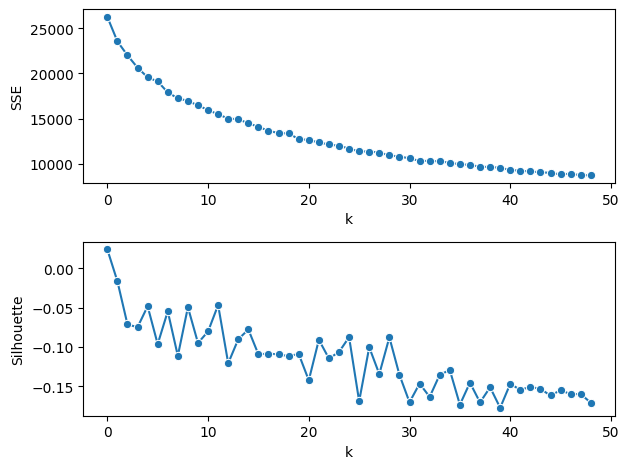

In [ ]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout()

## SULLA BASE DEI VALORI QUI SOPRA INIZIALIZZARE IL MODELLO CON IL NUMERO ADATTO DI K

### Inizializzazione modello

In [83]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100, random_state=94) #inizializziamo algoritmo, fit it per lavorare sull'exact data
#iniziamo con 3 cluster, 10 iterations, random_state: allows to have the same result 

#kmeans.fit(X_scal)
#kmeans.fit(X_minmax)
kmeans.fit(D_scaled) #---> numpy array di mixed matrix tra distanze di var numeriche e var binarie

KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=94)

### Visualizzazione cluster
#### ---> per selezionare le feature da mettere sugli assi, chat dice di valutare la correlation matrix

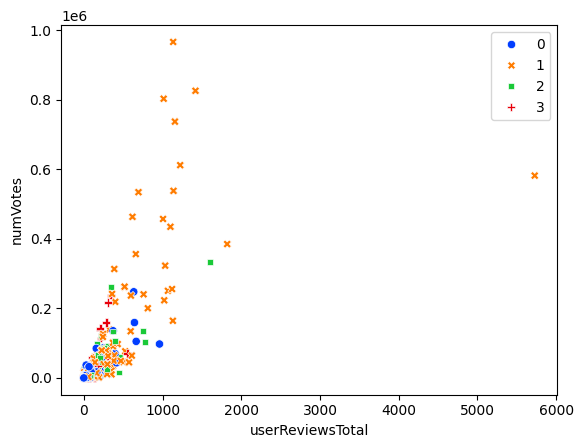

In [84]:
sns.scatterplot(data=pp_train_copy, 
                x="userReviewsTotal",
                y="numVotes",
                hue=kmeans.labels_,
                style=kmeans.labels_, #usiamo labels date da k-means
                palette="bright")
plt.show()

### SSE e silhouette

In [32]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X_minmax, kmeans.labels_))

SSE 20744.851480347956
Silhouette -0.08007610287110146


### Identificazione dei centroidi

In [33]:
kmeans.cluster_centers_ #coordinates with centroids

array([[ 1.94073453e-02,  2.07461841e-01,  1.66524144e-01,
         1.57420638e-02,  3.80291425e-01,  7.13329471e-02,
         2.35017697e-02,  9.54120064e-02,  1.11846610e-02,
         1.27994572e-01,  8.65671636e-02,  4.66671891e-01,
         3.65213422e-03,  4.56516777e-03,  2.71627482e-02,
         8.44556037e-03,  9.81511071e-03,  1.00000000e+00,
         2.05432550e-02,  1.18922620e-01,  1.82606711e-03,
         1.98584798e-02,  4.56516777e-03,  3.83474093e-02,
        -2.88397778e-17,  1.07281443e-02,  6.84775165e-03,
         1.84889295e-02,  3.60648254e-02,  5.38689797e-02,
         1.12531386e-01,  3.74343757e-02,  1.25085597e-01,
         9.13033554e-03,  4.99885871e-02,  2.18443278e-01,
         9.58685232e-03,  5.47820132e-03,  2.30540972e-02,
         7.76078521e-02],
       [ 2.79375055e-02,  1.41073821e-01,  1.10898566e-01,
         1.39965943e-02,  2.90992254e-01,  4.65693330e-02,
         2.66166558e-02,  9.36288089e-02,  2.21606648e-03,
         8.86296728e-02,  4.76

In [34]:
centers = scaler.inverse_transform(kmeans.cluster_centers_) #from normalized to input domain
centers

ValueError: operands could not be broadcast together with shapes (5,40) (12,) (5,40) 

In [180]:
pp_train['kmeans_labels'] = kmeans.labels_
pp_train['kmeans_labels'] = pp_train['kmeans_labels'].map({0:"A", 1: "B", 2: "C"})

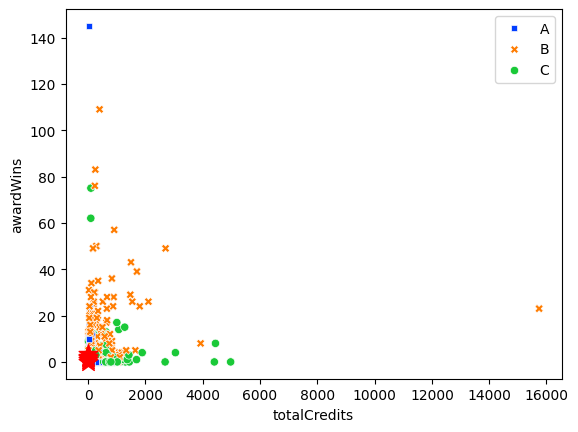

In [181]:
sns.scatterplot(data=pp_train, 
                x="totalCredits", 
                y="awardWins", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright", 
                hue_order=["A", "B", "C"]
               )
plt.legend()
#qui è giusto che centers sia :,1 se in quello di fedele dice [:,2]?
plt.scatter(centers[:,0], centers[:,2], c='red', marker='*', s=200) #plotting the centroids
plt.show()

#### Mapping della variabile target (per noi è titleType) così da confrontarla dopo con gli eventuali cluster/individuare quali cluster contengono un'alta percentuale di quale categoria di titleType

In [182]:
y = np.array(pp_train['titleType'])
y_map = {"tvEpisode": 0, "videoGame": 1, "movie": 2, "tvSeries": 3, "video": 4,
         "tvMiniSeries": 5, "short": 6, "tvMovie": 7, "tvSpecial": 8, "tvShort": 9}

y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map) #target label

### conronto con target variable

In [183]:
y_mapped

0        0
1        1
2        2
3        3
4        3
        ..
16426    2
16427    2
16428    2
16429    2
16430    6
Name: 0, Length: 16431, dtype: int64

In [184]:
y_mapped.groupby(pp_train['kmeans_labels']).value_counts(normalize=True)
#qui si vede quanta percentuale di titleType (i numeri da 0 a 9) appartiene a quale cluster (A, B, C)

kmeans_labels  0
A              0    0.286566
B              0    0.013752
A              1    0.015041
B              1    0.006876
               2    0.877210
A              2    0.546940
C              3    0.861021
B              3    0.033399
A              4    0.021006
B              4    0.012770
C              5    0.138979
B              5    0.002947
A              6    0.062241
B              6    0.012770
A              7    0.061203
B              7    0.039293
A              8    0.005965
B              8    0.000982
A              9    0.001037
Name: proportion, dtype: float64